In [1]:
import sys
sys.path.append("../")

In [2]:
import os.path as op
import random

import matplotlib.pyplot as plt
import pandas as pd
import yaml

from agents import GreedyAgent,RandomAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from agents.ml.regressionMulti import RegressionMultiAgent

from core.const import RED, BLUE
from core.game import GameBoard, GameState, vectorState, vectorStateInfo
from core.vectors import vectorAction, vectorActionInfo, vectorBoard, vectorBoardInfo
from scenarios import scenarioJunction
import warnings


from sklearn import preprocessing

from multiprocessing import Pool

from itertools import product
import json

import os



%matplotlib inline
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize'] = (12,4)


In [3]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    if data[0]=='ran':
        print(f'{team:5}-> RandomAgent')
        return RandomAgent(team, seed=seed)
    if data[0]=='regMulti':
        print(f'{team:5}-> RegressionAgentMulti')


        return RegressionMultiAgent(team,data[1],data[2],data[3],seed=seed)


    
    return None

In [4]:
def gameJunction(seed:int, red:tuple, blue:tuple) -> MatchManager:
    board, state = scenarioJunction()
    
    print('seed:   ', seed)
    
    playerRed = player(RED, red, seed)
    playerBlue = player(BLUE, blue, seed)

    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    
    print('winner: ', mm.winner)

    return mm

In [5]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )
    df_red = mm.red.createDataFrame()
    df_blue = mm.blue.createDataFrame()
    df_red['winner']=mm.winner
    df_blue['winner']=mm.winner
    
    df_red = df_red.set_index('count')
    df_blue = df_blue.set_index('count')

    return df_red, df_blue, df_states, df_actions

In [6]:
def plotEntropy(df, color:str,data,winner,ax):
    df.score.plot(color=color, marker='.',ax=ax)
    df.entropy.plot(color='purple',ax=ax)
    df.standard_deviation.plot(color='green',ax=ax)

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        ax.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        ax.axvline(x=x[0]+0.5, color='orange')
    ax.legend(framealpha=1, frameon=True,loc='center left',bbox_to_anchor=(1,0.5))
    title=f'Entropy and Score for agent->{data[0]}. Winner:{winner} '

    ax.set_title(title)


    

In [7]:
def setTime(df):
    df['time'] = pd.to_datetime(df['time'],errors='coerce')
    df['time']=df['time'].dt.time
    df= df.reset_index()
    df= df.set_index('time')
    return df


In [30]:
def plotEntropyTime(df_red,df_blue,red_data,blue_data,winner):
    df_red=setTime(df_red)
    df_blue=setTime(df_blue)
    ax=df_red.score.plot(color='red')
    df_red.entropy.plot(color='magenta',ax=ax,style=':')
    df_red.standard_deviation.plot(color='red',ax=ax,style='--')

    df_blue.score.plot(color='blue',ax=ax)
    df_blue.entropy.plot(color='cyan',ax=ax,style=':')
    df_blue.standard_deviation.plot(color='blue',ax=ax,style='--')
    
    markers={'Attack':'s',
             'AttackGround':'p',
             'Move':'*',
            'MoveLoadInto':'v',
            'PassFigure':'d',
             'Pass':'P',
             'PassTeam':'+',
             'AttackRespond':'x',
             'PassRespond':'1',
             'Response':'|' 
            }

    
    for a in df_red['action'].unique():
        df_red.loc[df_red["action"] == a].score.plot(color='black',marker=markers[a],linestyle='None',label=a)
    for a in df_blue['action'].unique():
        df_blue.loc[df_blue["action"] == a].score.plot(color='black',marker=markers[a],linestyle='None',label=a)

    
    for x in df_red[['turn']].reset_index().groupby('turn').last().values.tolist():
        ax.axvline(x=x[0], color='orange')
    ax.legend(framealpha=1, frameon=True,loc='center left',bbox_to_anchor=(1,0.5))
    title=f'Entropy and Score for red agent->{red_data[0]} and blue agent->{blue_data[0]} . Winner:{winner} '

    ax.set_title(title)




    

In [9]:
def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

In [10]:
def playAndAnalyzeTime(seed:int, red_data, blue_data):  
    mm = gameJunction(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner)
    
    plt.show()
    
    return df_red, df_blue

In [11]:
def playAndAnalyze(seed:int, red_data, blue_data):  
    mm = gameJunction(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
    plotEntropy(df_red, 'red',red_data,mm.winner,ax1)
    plotEntropy(df_blue, 'blue',blue_data,mm.winner,ax2)
    
    plt.show()
    
    return df_red, df_blue

In [12]:
def play(seed:int, red_data, blue_data):  
    mm = gameJunction(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    return df_red, df_blue

In [13]:
red_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_red_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_red_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_red_attack_20210301.joblib','../models/Junction_RandomForestRegressor_red_move_20210301.joblib','../models/Junction_RandomForestRegressor_red_pass_20210301.joblib')

]
blue_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_blue_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_blue_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_blue_attack_20210301.joblib','../models/Junction_RandomForestRegressor_blue_move_20210301.joblib','../models/Junction_RandomForestRegressor_blue_pass_20210301.joblib')


]

In [28]:
s=51

seed:    51
red  -> RegressionAgentMulti
blue -> RegressionAgent


Entropy out of range: 1.2536599577536294
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, -0.02, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, -0.02, 0.0, -0.02, -0.02, 0.0, -0.02, -0.02, 0.0, 0.0, -0.02, -0.02, -0.02, -0.02, 0.0, -0.02, 0.0, -0.02, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, -0.02, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, -0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34, 0.34, 0.34]
Entropy out of range: 1.0105517656233047
[0.38, 0.4, 0.38, 0.38, 0.38, 0.38, 0.36, 0.38, 0.38, 0.36, 0.38, 0.38, 0.38, 0.38, 0.36,

winner:  blue


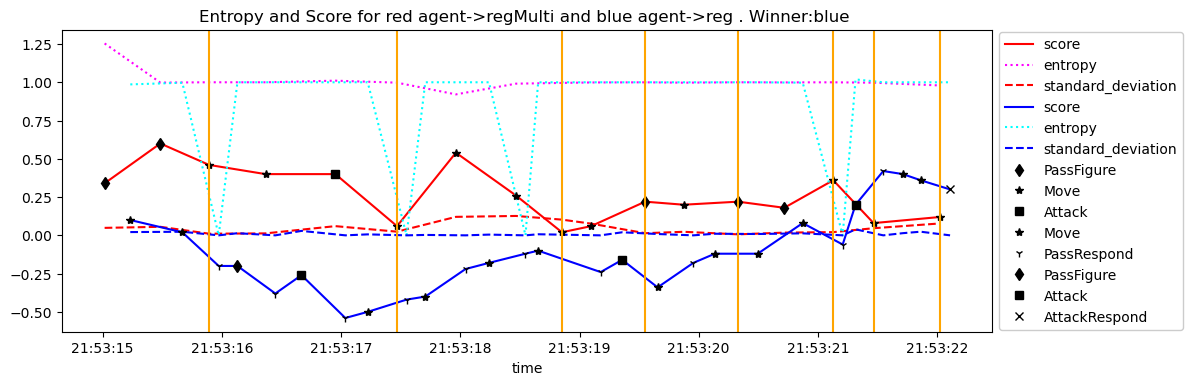

In [31]:
df_red,df_blue=playAndAnalyzeTime(s, red_models[5], blue_models[3])


seed:    51
red  -> GreedyAgent
blue -> RegressionAgent
winner:  blue


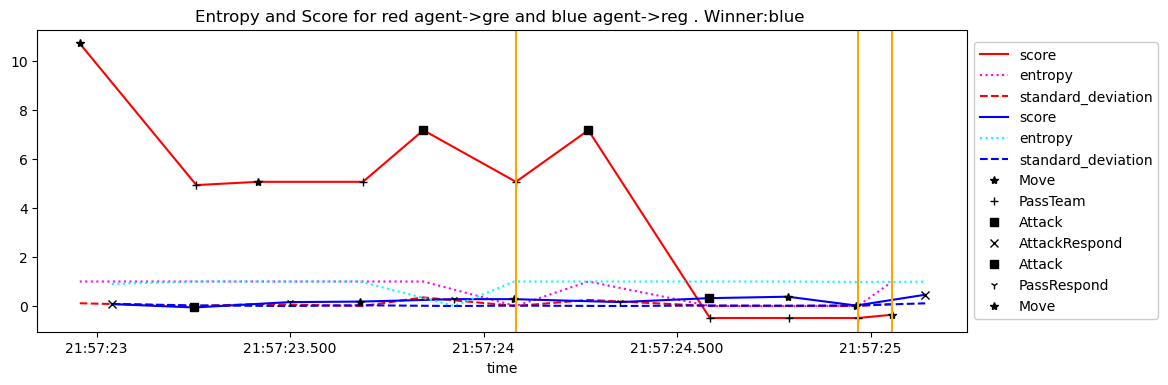

In [32]:
df_red,df_blue=playAndAnalyzeTime(s, red_models[0], blue_models[3])


seed:    1340
red  -> GreedyAgent
blue -> RegressionAgent


Entropy out of range: 1.0018746337318443
[-0.2, 0.36, -0.16, -0.18, -0.2, -0.14, -0.18, -0.16, -0.16, -0.18, -0.14, -0.16, -0.16, -0.18, -0.16, -0.2, -0.16, -0.16, -0.18, -0.2, -0.16, -0.16, -0.2, -0.18, -0.16, -0.16, -0.2, -0.16, -0.16, -0.16, -0.16, -0.18, -0.1, -0.18, -0.16, -0.2, -0.18, -0.2, -0.18, -0.16, -0.16, -0.16, -0.2, -0.18, -0.2, -0.16, -0.14, -0.18, -0.18, -0.16, -0.14, -0.2, -0.2, -0.16, -0.18, -0.18, -0.18, -0.14, -0.16, -0.14, -0.16, -0.2, -0.2, -0.14, -0.2, -0.18, -0.18, -0.16, -0.2, -0.14, -0.18, -0.14, -0.18, -0.2, -0.12, -0.2, 0.48, -0.24, -0.22, -0.24, -0.2, -0.24, -0.18, -0.16, -0.2, -0.18, -0.2, -0.18, -0.24, -0.16, -0.16, -0.16, -0.22, -0.22, -0.2, -0.22, -0.16, -0.2, -0.2, -0.24, -0.2, -0.16, -0.18, -0.22, -0.22, -0.22, -0.22, -0.18, -0.16, -0.16, -0.22, -0.22, -0.16]
No actions available: no response given
No actions available: no response given


winner:  red


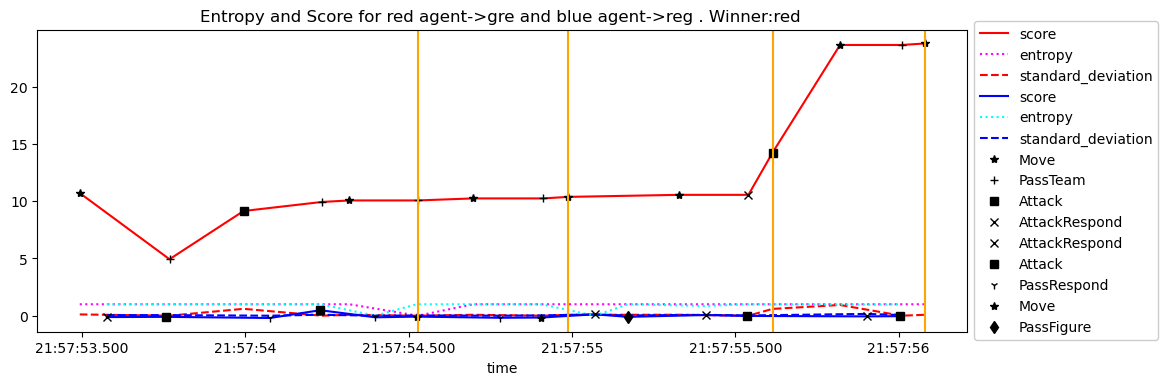

In [33]:
df_red,df_blue=playAndAnalyzeTime(1340, red_models[0], blue_models[3])


## Tourney 

seed:    60750
red  -> RegressionAgent
blue -> ClassifierAgent


Entropy out of range: 1.0064198543707275
[-0.06, -0.04, 0.2, 0.16, 0.16, 0.18, 0.18, 0.18, 0.16, 0.14, 0.12, 0.18, 0.12, 0.18, 0.12, 0.14, 0.18, 0.18, 0.2, 0.18, 0.16, 0.2, 0.18, 0.16, 0.18, 0.12, 0.12, 0.2, 0.14, 0.14, 0.12, 0.18, 0.14, 0.14, 0.2, 0.12, 0.12, 0.2, 0.12, 0.1, 0.16, 0.16, 0.14, 0.12, 0.12, 0.12, 0.16, 0.12, 0.2, 0.12, 0.16, 0.2, 0.12, 0.14, 0.16, 0.2, 0.16, 0.18, 0.18, 0.14, 0.18, 0.18, 0.16, 0.16, 0.12, 0.16, 0.2, 0.2, 0.16, 0.2, 0.2, 0.16, 0.18, 0.14, 0.2, 0.14, 0.12, 0.16, 0.16]
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
Entropy out of range: 1.0267967752028417
[0.0, 0.04, 0.04, 0.02, -0.02, 0.02, 0.04, 0.04, 0.0, 0.0, -0.02, 0.0, 0.04, 0.04, 0.02, 0.0, 0.02, 0.0, 0.0, 0.02, 0.04, 0.0, -0.02, -0.02, 0.04, 0.04, 0.0, -0.02, -0.02, 0.02

winner:  blue


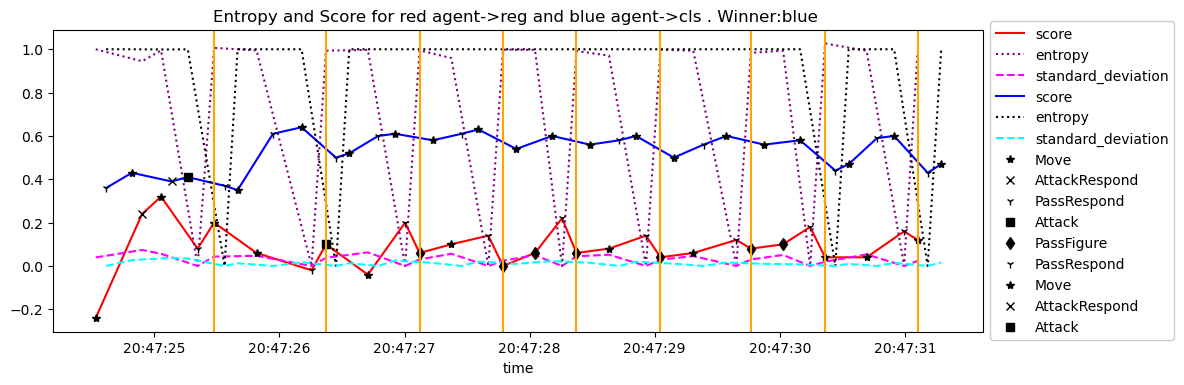

seed:    193867
red  -> RegressionAgent
blue -> GreedyAgent


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


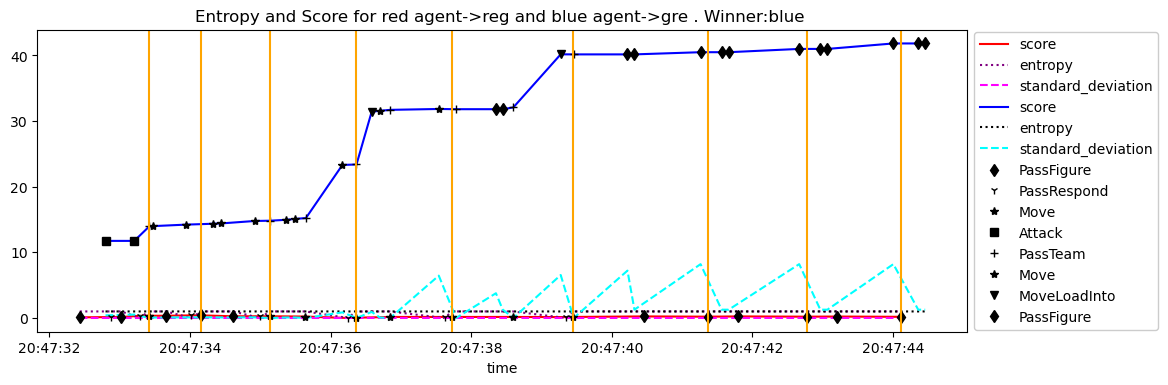

seed:    460499
red  -> ClassifierAgent
blue -> GreedyAgent


No actions available: no response given


winner:  blue


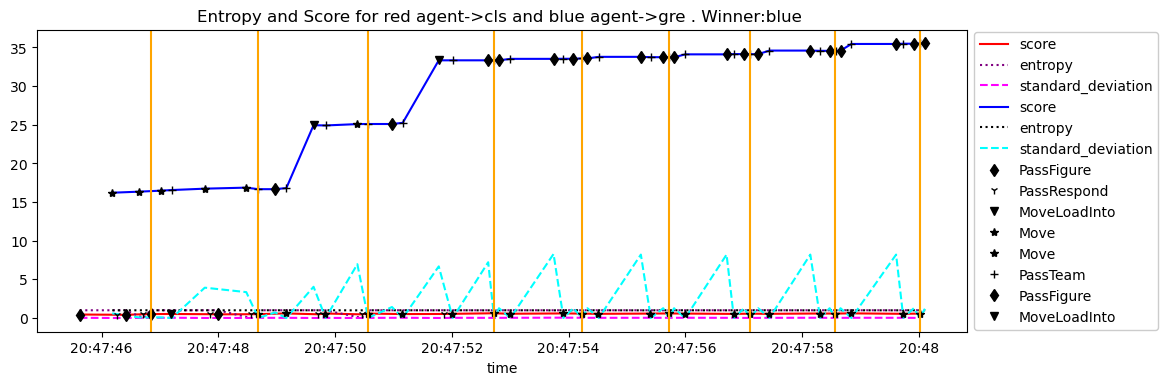

In [14]:
dfs=[]
for i in range(3):
    s = random.randint(0, 1000000)
    r = random.randint(0, len(red_models)-1)
    b = random.randint(0, len(blue_models)-1)
    df_red,df_blue=playAndAnalyzeTime(s, red_models[r], blue_models[b])
    dfs.append(df_red)
    dfs.append(df_blue)
df=pd.concat(dfs).reset_index()

## Entropy regressor

In [ ]:
def plotgroupAgentePartita(df,value_y,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=value_y, kind=kind,style='-o' ,ax=ax,title=title,ylim=[-1,1])

In [ ]:
plotgroupAgentePartita(df,'score','bar')

In [ ]:
plotgroupAgentePartita(df,'entropy','bar')

plotgroupAgentePartita(df,'Score','scatter')

plotgroupAgentePartita(df,'Entropia','scatter')

plotgroupAgentePartita(df,'Score','line')

plotgroupAgentePartita(df,'Entropia','line')

plotgroupAgentePartita(df,'Score','box')

plotgroupAgentePartita(df,'Entropia','box')

In [ ]:
def entropyAndScore(df,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=['score'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='r')
        group.plot(x='count', y=['entropy'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='b')

In [ ]:
entropyAndScore(df,'scatter')

entropyAndScore(df,'line')

fig, axes = plt.subplots(1,len(df['seed'].unique()), figsize=(15,5))
for (joinGroup, group), ax in zip(df.groupby(['seed']), axes.flatten()):
    win=group['winner'].unique()
    title=f'{joinGroup}-> winner:{win}'
    group.plot(x=['count'], y=['score'], kind='scatter', ax=ax,title=title,ylim=[-1,1],c='team')


plot=df.groupby(['team','seed']).plot.bar(y='entropy')

boxplot=df.boxplot(column=['score', 'entropy'],by='team')


boxplot=df.boxplot(column=['score', 'entropy'],by='seed')

boxplot=df.boxplot(column=['score', 'entropy'],by=['seed','team'])

plot=df.groupby('team').plot.scatter(x='count',y='entropy',c='team')

plot=df.groupby('team').plot.scatter(x='count',y='score',c='team')